In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
import scipy.stats 
import glob

In [2]:
#Import links and plotting settings
save_path = './Figures/Paper Figures/'

pal = sns.color_palette('winter', 3)
pal

[(0.0, 0.25098039215686274, 0.8745098039215686),
 (0.0, 0.5019607843137255, 0.7490196078431373),
 (0.0, 0.7529411764705882, 0.6235294117647059)]

In [25]:
#Functions
def plotScatter(x, y, colors, label, axis, labels = False, shape = None, lines = False):
    sns.scatterplot(x = x, y = y, hue = colors,
                    palette = pal,
                    linewidth = 0,
                    style = shape,
                    ax = axis, legend = labels)
    #axis.set_ylim(0, 0.005)
    axis.set_xlabel(label)
    s, _, _, p, _ = scipy.stats.linregress(x, y)
    axis.annotate(r"$\beta$ = {:.4f}, p = {:.2f}".format(s, p), (min(x), max(y)))
    for i in set(colors):
        temp_x = x[colors == i]
        temp_y = y[colors == i]
        if((len(temp_x) > 0)& (len(temp_y) > 0)):
            slope, intercept, _, p_value, _ = scipy.stats.linregress(temp_x, temp_y)
            axis.annotate(str(i) + r": $\beta$ = {:.4f}, p = {:.2f}".format(slope, p_value), (min(x), max(temp_y)))
            if(lines):
                x_range = np.linspace(start = min(temp_x), stop = max(temp_x), num = 50)
                y_range = slope*x_range + intercept
                sns.lineplot(x = x_range, y = y_range, ax = axis)

In [4]:
#Import MI Data
file_list = glob.glob("MI data/*.csv")

miData = pd.DataFrame()

for file in file_list:
    dat = pd.read_csv(file, index_col= 0)
    dat['frost_level'] = file[25:28]
    dat['lag'] = int(file[-5])

    miData = pd.concat([miData, dat]).reset_index(drop = True)

#Import Seasonal Data
data_nas = pd.read_csv('./mef-data/data_compiled_gapfilled_seasonal.csv')
data = data_nas.dropna().reset_index(drop = True)
data = data[data.year != 2014]

#Shift dates forward for lag 1 plots
data = data.sort_values(['year', 'season'], ascending = [True, False]).reset_index(drop = True)
data_lag1 = data[1:-1].reset_index(drop = True)
data_lag1['sourceSeason'] = data.season
for col in ['South_PCP', 'WTE', 'Snow_in', 'MEANC', 'd.15_S2E', 'd.15_S2S', 'd.76_S2E', 'd.76_S2S', 'd.137_S2E', 'd.137_S2S']:
    data_lag1[col] = data[col]

#Shift dates forward for lag 2 plots
data_lag2 = data[2:-1].reset_index(drop = True)
data_lag2['sourceSeason'] = data.season
for col in ['South_PCP', 'WTE', 'Snow_in', 'MEANC', 'd.15_S2E', 'd.15_S2S', 'd.76_S2E', 'd.76_S2S', 'd.137_S2E', 'd.137_S2S']:
    data_lag2[col] = data[col]

#Merge lagged dataframes with an indicator column for lag
data['lag'] = 0
data['sourceSeason'] = data.season
data_lag1['lag'] = 1
data_lag2['lag'] = 2
data_merged = pd.concat([data, data_lag1, data_lag2]).reset_index(drop = True)

#Import Soil frost data
#Upland Frost Depths
infile2  ="https://pasta.lternet.edu/package/data/eml/edi/571/3/cf159d50f0e80a99b14830103eec9297".strip() 
infile2  = infile2.replace("https://","http://")
                 
upFrost =pd.read_csv(infile2, skiprows=1, sep=",",
                names=["Watershed", "SnowcourseID", "Date", "Point", "FrostDEPTH"],
                parse_dates=['Date'] 
    )
# Coerce the data into the types specified in the metadata 
upFrost.Point=upFrost.Point.astype('category') 
upFrost.FrostDEPTH=pd.to_numeric(upFrost.FrostDEPTH,errors='coerce',downcast='integer')    

upFrost = upFrost[upFrost.Watershed == 'S2'].reset_index(drop = True)
upFrost['year'] = upFrost.Date.dt.year

upFrostAnnual = upFrost.groupby(['year', 'SnowcourseID'])['FrostDEPTH'].mean().reset_index()
upFrostAnnual = upFrostAnnual.pivot(index = 'year', columns = 'SnowcourseID', values = 'FrostDEPTH').reset_index()
upFrostAnnual['courseMean'] = upFrostAnnual[['S21', 'S22', 'S23']].mean(axis=1)

#Merge with the seasonal totals
data_merged_frost = data_merged.merge(upFrostAnnual, on = 'year', how = 'outer')
#Remove nan rows
data_merged_frost = data_merged_frost.dropna()
#rename columns
data_merged_frost = data_merged_frost.rename(columns = {'S21':'S21_FDpth', 'S22':'S22_FDpth', 'S23':'S23_FDpth'})
#frost quants
data_merged_frost['frostQuant'] = pd.qcut(data_merged_frost['courseMean'], 3, labels = ['Low', 'Med', 'High'])

C:\Users\marie\AppData\Local\Temp\ipykernel_15176\1500571785.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  melt_midata['TE_cum'] = melt_midata.sort_values('lag', ascending = False).groupby(['variable', 'frost_level'])['value'].cumsum()
C:\Users\marie\AppData\Local\Temp\ipykernel_15176\1500571785.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Grow - Melt', 'Snow - Melt', 'Melt'])


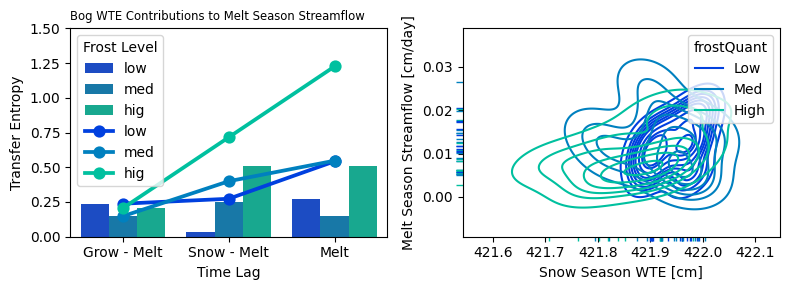

In [5]:
#Q1 effects of water table plot
melt_midata = miData[miData.season_target == 'Melt']
melt_midata['TE_cum'] = melt_midata.sort_values('lag', ascending = False).groupby(['variable', 'frost_level'])['value'].cumsum()

fig, [ax, ax2] = plt.subplots(1, 2, figsize = (8, 3), 
                                    layout = 'tight')

sns.barplot(data = melt_midata[melt_midata.variable == 'WTE'], y = 'value', x = 'lag', order = [2, 1, 0],
            hue = 'frost_level', hue_order = ['low', 'med', 'hig'],
            palette = 'winter', ax = ax)
sns.pointplot(data = melt_midata[melt_midata.variable == 'WTE'], y = 'TE_cum', x = 'lag', order = [2, 1, 0],
            hue = 'frost_level', hue_order = ['low', 'med', 'hig'],
            palette = 'winter', ax = ax)
ax.set_ylim(0, 1.5)
ax.set_xticklabels(['Grow - Melt', 'Snow - Melt', 'Melt'])
ax.legend(loc = 'upper left', title = 'Frost Level')
ax.set_ylabel('Transfer Entropy')
ax.set_xlabel('Time Lag')
ax.set_title('Bog WTE Contributions to Melt Season Streamflow', fontsize = 'small', loc = 'left')

temp_dat = data_merged_frost[(data_merged_frost.season == 'Melt') & (data_merged_frost.lag == 1)]
sns.kdeplot(x = temp_dat.WTE, y = temp_dat.mean_cmDay, hue = temp_dat.frostQuant,
            palette = 'winter', ax = ax2)
sns.rugplot(x = temp_dat.WTE, y = temp_dat.mean_cmDay, hue = temp_dat.frostQuant,
            height=-.02, clip_on = False,
            palette = 'winter', ax = ax2)
ax2.set_xlabel('Snow Season WTE [cm]')
ax2.set_ylabel('Melt Season Streamflow [cm/day]')

plt.savefig(save_path + 'Q1_snowWTEcontrib.pdf', bbox_inches = 'tight')
plt.savefig(save_path + 'Q1_snowWTEcontrib.jpeg', bbox_inches = 'tight')


C:\Users\marie\AppData\Local\Temp\ipykernel_15176\1407166001.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Grow - Melt', 'Snow - Melt', 'Melt'])
C:\Users\marie\AppData\Local\Temp\ipykernel_15176\1407166001.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(['Grow - Melt', 'Snow - Melt', 'Melt'])
C:\Users\marie\AppData\Local\Temp\ipykernel_15176\1407166001.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax3.set_xticklabels(['Grow - Melt', 'Snow - Melt', 'Melt'])


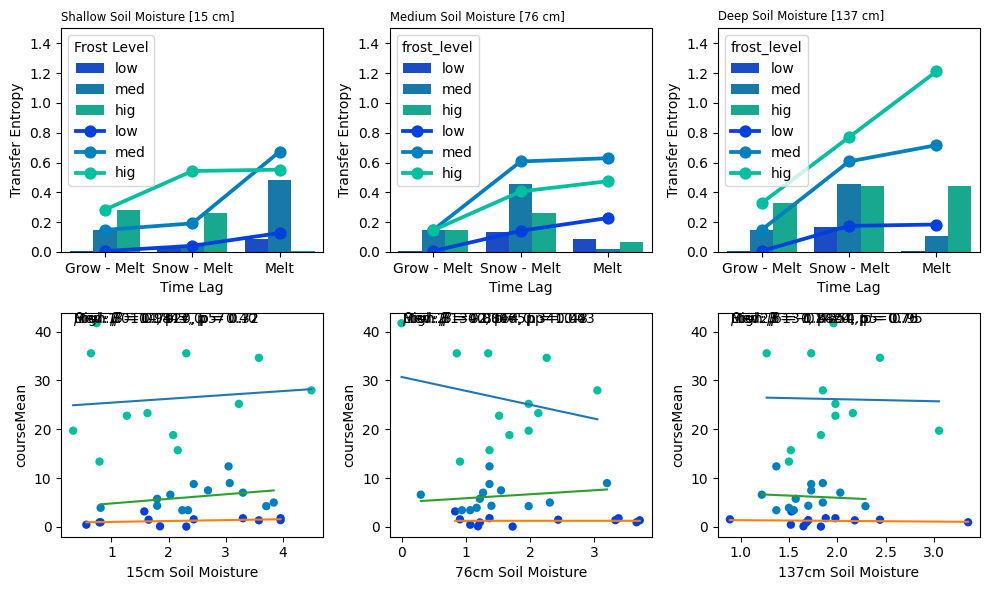

In [10]:
#Q1 effects of soil moisture plot

fig, [[ax, ax2, ax3], [ax4, ax5, ax6]] = plt.subplots(2, 3, figsize = (10, 6), 
                                    layout = 'tight')

sns.barplot(data = melt_midata[melt_midata.variable == 'd.15'], y = 'value', x = 'lag', order = [2, 1, 0],
            hue = 'frost_level', hue_order = ['low', 'med', 'hig'],
            palette = 'winter', ax = ax)
sns.pointplot(data = melt_midata[melt_midata.variable == 'd.15'], y = 'TE_cum', x = 'lag', order = [2, 1, 0],
            hue = 'frost_level', hue_order = ['low', 'med', 'hig'],
            palette = 'winter', ax = ax)
ax.set_ylim(0, 1.5)
ax.set_xticklabels(['Grow - Melt', 'Snow - Melt', 'Melt'])
ax.legend(loc = 'upper left', title = 'Frost Level')
ax.set_ylabel('Transfer Entropy')
ax.set_xlabel('Time Lag')
ax.set_title('Shallow Soil Moisture [15 cm]', fontsize = 'small', loc = 'left')

sns.barplot(data = melt_midata[melt_midata.variable == 'd.76'], y = 'value', x = 'lag', order = [2, 1, 0],
            hue = 'frost_level', hue_order = ['low', 'med', 'hig'],
            palette = 'winter', ax = ax2)
sns.pointplot(data = melt_midata[melt_midata.variable == 'd.76'], y = 'TE_cum', x = 'lag', order = [2, 1, 0],
            hue = 'frost_level', hue_order = ['low', 'med', 'hig'],
            palette = 'winter', ax = ax2)
ax2.set_ylim(0, 1.5)
ax2.set_xticklabels(['Grow - Melt', 'Snow - Melt', 'Melt'])
ax2.set_ylabel('Transfer Entropy')
ax2.set_xlabel('Time Lag')
ax2.set_title('Medium Soil Moisture [76 cm]', fontsize = 'small', loc = 'left')

sns.barplot(data = melt_midata[melt_midata.variable == 'd.137'], y = 'value', x = 'lag', order = [2, 1, 0],
            hue = 'frost_level', hue_order = ['low', 'med', 'hig'],
            palette = 'winter', ax = ax3)
sns.pointplot(data = melt_midata[melt_midata.variable == 'd.137'], y = 'TE_cum', x = 'lag', order = [2, 1, 0],
            hue = 'frost_level', hue_order = ['low', 'med', 'hig'],
            palette = 'winter', ax = ax3)
ax3.set_ylim(0, 1.5)
ax3.set_xticklabels(['Grow - Melt', 'Snow - Melt', 'Melt'])
ax3.set_ylabel('Transfer Entropy')
ax3.set_xlabel('Time Lag')
ax3.set_title('Deep Soil Moisture [137 cm]', fontsize = 'small', loc = 'left')

temp_dat = data_merged_frost[(data_merged_frost.season == 'Melt') & (data_merged_frost.lag == 2)]
plotScatter(x = temp_dat['d.15_S2E'], y = temp_dat['courseMean'], colors = temp_dat.frostQuant,
            axis = ax4, label = '15cm Soil Moisture', lines = True)
plotScatter(x = temp_dat['d.76_S2E'], y = temp_dat['courseMean'], colors = temp_dat.frostQuant,
            axis = ax5, label = '76cm Soil Moisture', lines = True)
plotScatter(x = temp_dat['d.137_S2E'], y = temp_dat['courseMean'], colors = temp_dat.frostQuant,
            axis = ax6, label = '137cm Soil Moisture', lines = True)

plt.savefig(save_path + 'Q1_soilcontrib.pdf', bbox_inches = 'tight')
plt.savefig(save_path + 'Q1_soilcontrib.jpeg', bbox_inches = 'tight')

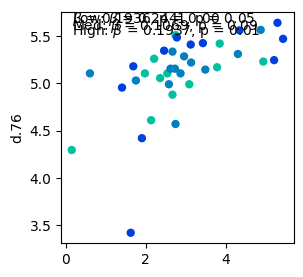

In [57]:
data_merged_frost['d.15'] = 0.5*(data_merged_frost['d.15_S2S'] + data_merged_frost['d.15_S2E'])
data_merged_frost['d.76'] = 0.5*(data_merged_frost['d.76_S2S'] + data_merged_frost['d.76_S2E'])
data_merged_frost['d.137'] = 0.5*(data_merged_frost['d.137_S2S'] + data_merged_frost['d.137_S2E'])
temp_datGrowing = data_merged_frost[(data_merged_frost.season == 'Melt') & (data_merged_frost.lag == 2)].reset_index(drop = True)
temp_datSnow = data_merged_frost[(data_merged_frost.season == 'Melt') & (data_merged_frost.lag == 1)][1:].reset_index(drop = True)
temp_datMelt = data_merged_frost[(data_merged_frost.season == 'Melt') & (data_merged_frost.lag == 0)][1:].reset_index(drop = True)


fig, ax = plt.subplots(1, 1, figsize = (3,3))
plotScatter(x = temp_datGrowing['d.76'], y = temp_datMelt['d.76'], colors = temp_datGrowing['frostQuant'], label = '', axis = ax)

C:\Users\marie\AppData\Local\Temp\ipykernel_15176\507846871.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  snow_midata['TE_cum'] = snow_midata.sort_values('lag', ascending = True).groupby(['variable', 'frost_level'])['value'].cumsum()
C:\Users\marie\AppData\Local\Temp\ipykernel_15176\507846871.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Snow', 'Snow - Melt', 'Snow - Grow'])
C:\Users\marie\AppData\Local\Temp\ipykernel_15176\507846871.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax3.set_xticklabels(['Snow', 'Snow - Melt', 'Snow - Grow'])
C:\

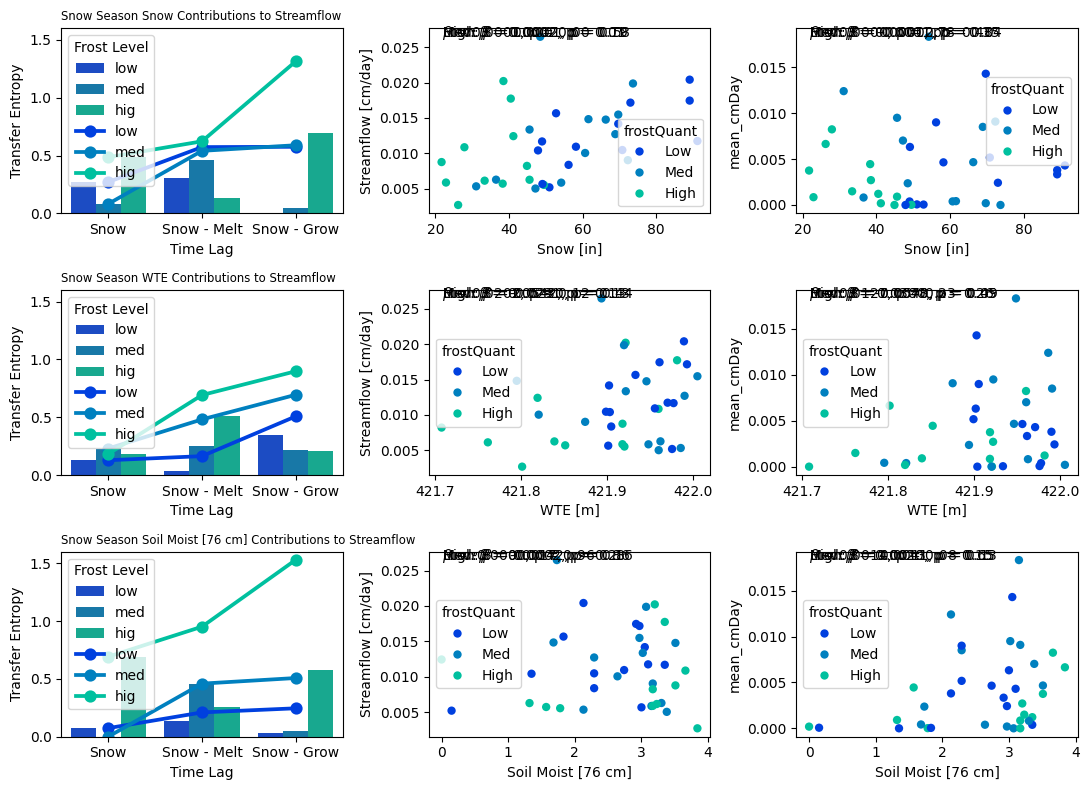

In [7]:
#Q2 snow season snow on streamflow plot
snow_midata = miData[miData.season_source == 'Snow']
snow_midata['TE_cum'] = snow_midata.sort_values('lag', ascending = True).groupby(['variable', 'frost_level'])['value'].cumsum()

#Snow
fig, [[ax, ax2, ax22], [ax3, ax4, ax44], [ax5, ax6, ax66]] = plt.subplots(3, 3, figsize = (11, 8), 
                                    layout = 'tight')

sns.barplot(data = snow_midata[snow_midata.variable == 'Snow_in'], y = 'value', x = 'lag', order = [0, 1, 2],
            hue = 'frost_level', hue_order = ['low', 'med', 'hig'],
            palette = 'winter', ax = ax)
sns.pointplot(data = snow_midata[snow_midata.variable == 'Snow_in'], y = 'TE_cum', x = 'lag', order = [0, 1, 2],
            hue = 'frost_level', hue_order = ['low', 'med', 'hig'],
            palette = 'winter', ax = ax)
ax.set_ylim(0, 1.6)
ax.set_xticklabels(['Snow', 'Snow - Melt', 'Snow - Grow'])
ax.legend(loc = 'upper left', title = 'Frost Level')
ax.set_ylabel('Transfer Entropy')
ax.set_xlabel('Time Lag')
ax.set_title('Snow Season Snow Contributions to Streamflow', fontsize = 'small', loc = 'left')

temp_dat_melt = data_merged_frost[(data_merged_frost['sourceSeason'] == 'Snow') & (data_merged_frost['season'] == 'Melt')]
temp_dat_grow = data_merged_frost[(data_merged_frost['sourceSeason'] == 'Snow') & (data_merged_frost['season'] == 'Growing')]
plotScatter(temp_dat_melt.Snow_in, temp_dat_melt.mean_cmDay, temp_dat_melt.frostQuant, 'Snow [in]', ax2, labels = True)
plotScatter(temp_dat_grow.Snow_in, temp_dat_grow.mean_cmDay, temp_dat_grow.frostQuant, 'Snow [in]', ax22, labels = True)
ax2.set_ylabel('Streamflow [cm/day]')

#WTE
sns.barplot(data = snow_midata[snow_midata.variable == 'WTE'], y = 'value', x = 'lag', order = [0, 1, 2],
            hue = 'frost_level', hue_order = ['low', 'med', 'hig'],
            palette = 'winter', ax = ax3)
sns.pointplot(data = snow_midata[snow_midata.variable == 'WTE'], y = 'TE_cum', x = 'lag', order = [0, 1, 2],
            hue = 'frost_level', hue_order = ['low', 'med', 'hig'],
            palette = 'winter', ax = ax3)
ax3.set_ylim(0, 1.6)
ax3.set_xticklabels(['Snow', 'Snow - Melt', 'Snow - Grow'])
ax3.legend(loc = 'upper left', title = 'Frost Level')
ax3.set_ylabel('Transfer Entropy')
ax3.set_xlabel('Time Lag')
ax3.set_title('Snow Season WTE Contributions to Streamflow', fontsize = 'small', loc = 'left')

plotScatter(temp_dat_melt.WTE, temp_dat_melt.mean_cmDay, temp_dat_melt.frostQuant, 'WTE [m]', ax4, labels = True)
plotScatter(temp_dat_grow.WTE, temp_dat_grow.mean_cmDay, temp_dat_grow.frostQuant, 'WTE [m]', ax44, labels = True)
ax4.set_ylabel('Streamflow [cm/day]')

#Shallow Soil Moisture
sns.barplot(data = snow_midata[snow_midata.variable == 'd.76'], y = 'value', x = 'lag', order = [0, 1, 2],
            hue = 'frost_level', hue_order = ['low', 'med', 'hig'],
            palette = 'winter', ax = ax5)
sns.pointplot(data = snow_midata[snow_midata.variable == 'd.76'], y = 'TE_cum', x = 'lag', order = [0, 1, 2],
            hue = 'frost_level', hue_order = ['low', 'med', 'hig'],
            palette = 'winter', ax = ax5)
ax5.set_ylim(0, 1.6)
ax5.set_xticklabels(['Snow', 'Snow - Melt', 'Snow - Grow'])
ax5.legend(loc = 'upper left', title = 'Frost Level')
ax5.set_ylabel('Transfer Entropy')
ax5.set_xlabel('Time Lag')
ax5.set_title('Snow Season Soil Moist [76 cm] Contributions to Streamflow', fontsize = 'small', loc = 'left')

plotScatter(temp_dat_melt['d.76_S2E'], temp_dat_melt.mean_cmDay, temp_dat_melt.frostQuant, 'Soil Moist [76 cm]', ax6, labels = True)
plotScatter(temp_dat_grow['d.76_S2E'], temp_dat_grow.mean_cmDay, temp_dat_grow.frostQuant, 'Soil Moist [76 cm]', ax66, labels = True)
ax6.set_ylabel('Streamflow [cm/day]')

plt.savefig(save_path + 'Q2_snowsourcecontrib.pdf', bbox_inches = 'tight')
plt.savefig(save_path + 'Q2_snowsourcecontrib.jpeg', bbox_inches = 'tight')

C:\Users\marie\AppData\Local\Temp\ipykernel_15176\3306626487.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  melt_source_midata['TE_cum'] = melt_source_midata.sort_values('lag', ascending = True).groupby(['variable', 'frost_level'])['value'].cumsum()
C:\Users\marie\AppData\Local\Temp\ipykernel_15176\3306626487.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Melt', 'Melt - Grow', 'Melt - Snow'])
C:\Users\marie\AppData\Local\Temp\ipykernel_15176\3306626487.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax3.set_xticklabels(['Melt', 'Melt - Grow', 'M

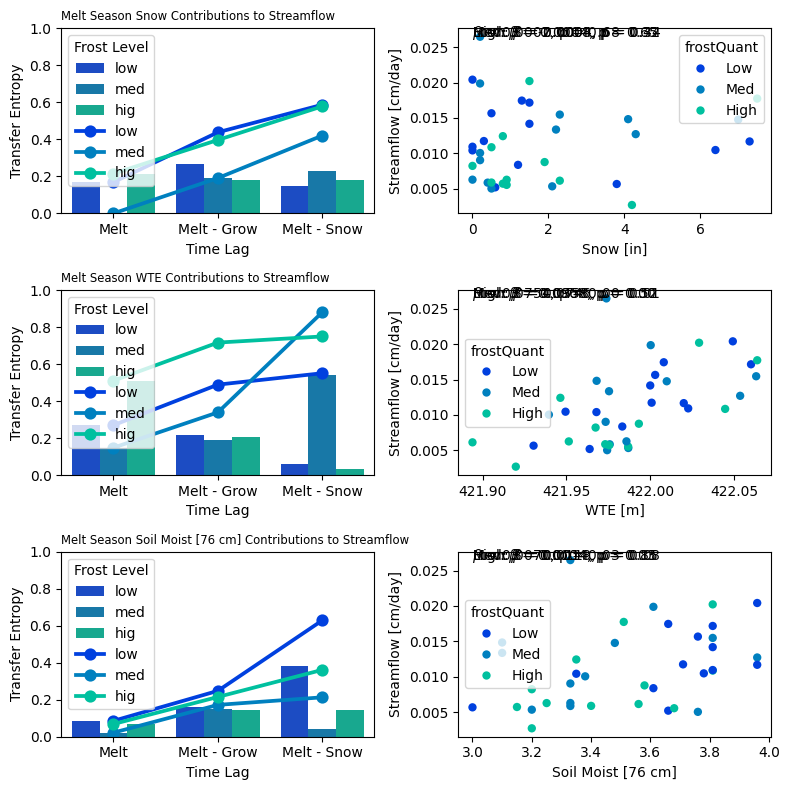

In [8]:
#Q2 snow season snow on streamflow plot
melt_source_midata = miData[miData.season_source == 'Melt']
melt_source_midata['TE_cum'] = melt_source_midata.sort_values('lag', ascending = True).groupby(['variable', 'frost_level'])['value'].cumsum()

#Snow
fig, [[ax, ax2], [ax3, ax4], [ax5, ax6]] = plt.subplots(3, 2, figsize = (8, 8), 
                                    layout = 'tight')

sns.barplot(data = melt_source_midata[melt_source_midata.variable == 'Snow_in'], y = 'value', x = 'lag', order = [0, 1, 2],
            hue = 'frost_level', hue_order = ['low', 'med', 'hig'],
            palette = 'winter', ax = ax)
sns.pointplot(data = melt_source_midata[melt_source_midata.variable == 'Snow_in'], y = 'TE_cum', x = 'lag', order = [0, 1, 2],
            hue = 'frost_level', hue_order = ['low', 'med', 'hig'],
            palette = 'winter', ax = ax)
ax.set_ylim(0, 1)
ax.set_xticklabels(['Melt', 'Melt - Grow', 'Melt - Snow'])
ax.legend(loc = 'upper left', title = 'Frost Level')
ax.set_ylabel('Transfer Entropy')
ax.set_xlabel('Time Lag')
ax.set_title('Melt Season Snow Contributions to Streamflow', fontsize = 'small', loc = 'left')

temp_dat = data_merged_frost[(data_merged_frost['sourceSeason'] == 'Melt') & (data_merged_frost['season'] == 'Melt')]
plotScatter(temp_dat.Snow_in, temp_dat.mean_cmDay, temp_dat.frostQuant, 'Snow [in]', ax2, labels = True)
ax2.set_ylabel('Streamflow [cm/day]')

#WTE
sns.barplot(data = melt_source_midata[melt_source_midata.variable == 'WTE'], y = 'value', x = 'lag', order = [0, 1, 2],
            hue = 'frost_level', hue_order = ['low', 'med', 'hig'],
            palette = 'winter', ax = ax3)
sns.pointplot(data = melt_source_midata[melt_source_midata.variable == 'WTE'], y = 'TE_cum', x = 'lag', order = [0, 1, 2],
            hue = 'frost_level', hue_order = ['low', 'med', 'hig'],
            palette = 'winter', ax = ax3)
ax3.set_ylim(0, 1)
ax3.set_xticklabels(['Melt', 'Melt - Grow', 'Melt - Snow'])
ax3.legend(loc = 'upper left', title = 'Frost Level')
ax3.set_ylabel('Transfer Entropy')
ax3.set_xlabel('Time Lag')
ax3.set_title('Melt Season WTE Contributions to Streamflow', fontsize = 'small', loc = 'left')

plotScatter(temp_dat.WTE, temp_dat.mean_cmDay, temp_dat.frostQuant, 'WTE [m]', ax4, labels = True)
ax4.set_ylabel('Streamflow [cm/day]')

#Shallow Soil Moisture
sns.barplot(data = melt_source_midata[melt_source_midata.variable == 'd.76'], y = 'value', x = 'lag', order = [0, 1, 2],
            hue = 'frost_level', hue_order = ['low', 'med', 'hig'],
            palette = 'winter', ax = ax5)
sns.pointplot(data = melt_source_midata[melt_source_midata.variable == 'd.76'], y = 'TE_cum', x = 'lag', order = [0, 1, 2],
            hue = 'frost_level', hue_order = ['low', 'med', 'hig'],
            palette = 'winter', ax = ax5)
ax5.set_ylim(0, 1)
ax5.set_xticklabels(['Melt', 'Melt - Grow', 'Melt - Snow'])
ax5.legend(loc = 'upper left', title = 'Frost Level')
ax5.set_ylabel('Transfer Entropy')
ax5.set_xlabel('Time Lag')
ax5.set_title('Melt Season Soil Moist [76 cm] Contributions to Streamflow', fontsize = 'small', loc = 'left')

plotScatter(temp_dat['d.76_S2E'], temp_dat.mean_cmDay, temp_dat.frostQuant, 'Soil Moist [76 cm]', ax6, labels = True)
ax6.set_ylabel('Streamflow [cm/day]')

plt.savefig(save_path + 'Q2_meltsourcecontrib.pdf', bbox_inches = 'tight')
plt.savefig(save_path + 'Q2_meltsourcecontrib.jpeg', bbox_inches = 'tight')